#### Import libraries

In [14]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from collections import deque
from scipy.ndimage.measurements import label
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from skimage.util.shape import view_as_windows
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers import Convolution2D, Conv2D, MaxPool2D, BatchNormalization, Input, Activation
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Build & train the Neural Network

#### Load  Classes

In [ ]:
# %load HogClasses.py

In [16]:
obj_image_processor_nn = ImageProcessingNN()

### Load the training images

Read in all the data

In [17]:
notcars = glob.glob('data\\non-vehicles\\*.png', recursive=True)
cars = glob.glob('data\\vehicles\\*.png', recursive=True)

color_space = 'LUV'
car_images = obj_image_processor_nn.read_images(cars, color_space=color_space)
notcar_images = obj_image_processor_nn.read_images(notcars, color_space=color_space)

Process the images and create the labels:

In [6]:
# Define the labels vector
y = np.hstack((np.ones(len(car_images)), np.zeros(len(notcar_images)))).reshape(-1,1)
#Equalize and resize the training data
X = np.concatenate((car_images, notcar_images), 0) #No equalization
X = obj_image_processor_nn.resize(X)
X, y = shuffle(X, y)

#### Initalize & train the classifier

Define CNN in Keras and initialize

In [7]:
def Convolution(input_tensor,filters):
        '''
        Define the Convolution layer
        '''
        x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
        x = Dropout(0.1)(x)
        x= Activation('relu')(x)
        return x
    
def model(input_shape):
        '''
        Model definition
        '''
        inputs = Input((input_shape))
        conv_1= Convolution(inputs,32)
        maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
        conv_2 = Convolution(maxp_1,64)
        maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
        conv_3 = Convolution(maxp_2,128)
        maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
        conv_4 = Convolution(maxp_3,256)
        maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
        flatten= Flatten() (maxp_4)
        dense_1= Dense(128,activation='relu')(flatten)
        drop_1=Dropout(0.2)(dense_1)
        output= Dense(1,activation="sigmoid")(drop_1)
        model = Model(inputs=[inputs], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer="Adam",metrics=["accuracy"])
        return model
#Build & compile the model
model = model(input_shape = (32, 32,3))
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                             

In [8]:
callback = EarlyStopping(patience=4, restore_best_weights=True)
# fit model
history = model.fit(X, y, epochs = 25, validation_split=0.2,callbacks =[callback], batch_size = 512, verbose = 1)

Epoch 1/25
21/21 [==============================] - 31s 1s/step - loss: 4.9324 - accuracy: 0.6304 - val_loss: 0.7034 - val_accuracy: 0.8442
Epoch 2/25
21/21 [==============================] - 27s 1s/step - loss: 0.5930 - accuracy: 0.8682 - val_loss: 0.5133 - val_accuracy: 0.9229
Epoch 3/25
21/21 [==============================] - 25s 1s/step - loss: 0.4869 - accuracy: 0.9132 - val_loss: 0.4365 - val_accuracy: 0.9460
Epoch 4/25
21/21 [==============================] - 25s 1s/step - loss: 0.4228 - accuracy: 0.9422 - val_loss: 0.4018 - val_accuracy: 0.9578
Epoch 5/25
21/21 [==============================] - 26s 1s/step - loss: 0.3796 - accuracy: 0.9562 - val_loss: 0.3730 - val_accuracy: 0.9639
Epoch 6/25
21/21 [==============================] - 24s 1s/step - loss: 0.3494 - accuracy: 0.9676 - val_loss: 0.3408 - val_accuracy: 0.9715
Epoch 7/25
21/21 [==============================] - 24s 1s/step - loss: 0.3345 - accuracy: 0.9723 - val_loss: 0.3305 - val_accuracy: 0.9723
Epoch 8/25
21/21 [==

save the classifier

In [9]:
model.save('Vehicle_Detection_CNN.h5')

In [10]:
np.save('Vehicle_Detection_CNN_history.npy',history.history)

Load a previously trained model

In [18]:
model_cnn = load_model('Vehicle_Detection_CNN.h5')
history=np.load('Vehicle_Detection_CNN_history.npy',allow_pickle='TRUE').item()

show accuracy and loss model

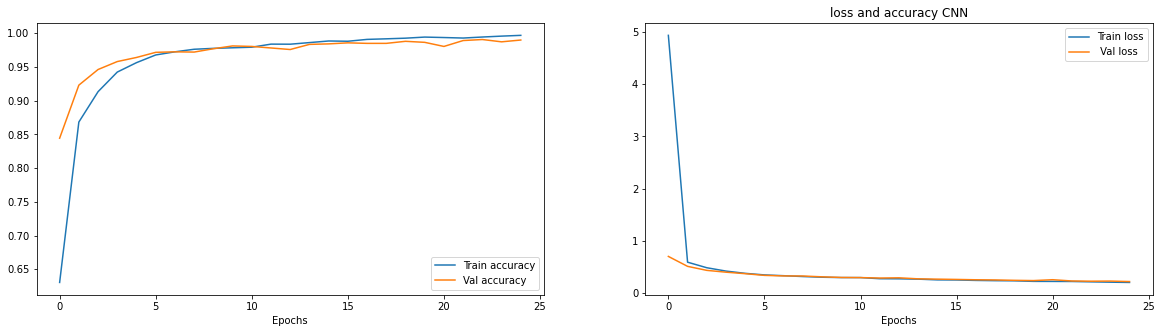

In [31]:
def loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(history['accuracy'], label='Train accuracy')
    axes[0].plot(history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    plt.title('loss and accuracy CNN')
    axes[1].plot(history['loss'], label='Train loss')
    axes[1].plot(history['val_loss'], label=' Val loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    plt.savefig('loss_and_accuracy_CNN.png')

loss_and_accuracy(history)

## Detect vehicles on the test images

In [20]:
processor = processDataNN(model_cnn)

#### Read in all the test images

Test images shape is: (4, 720, 1280, 3)


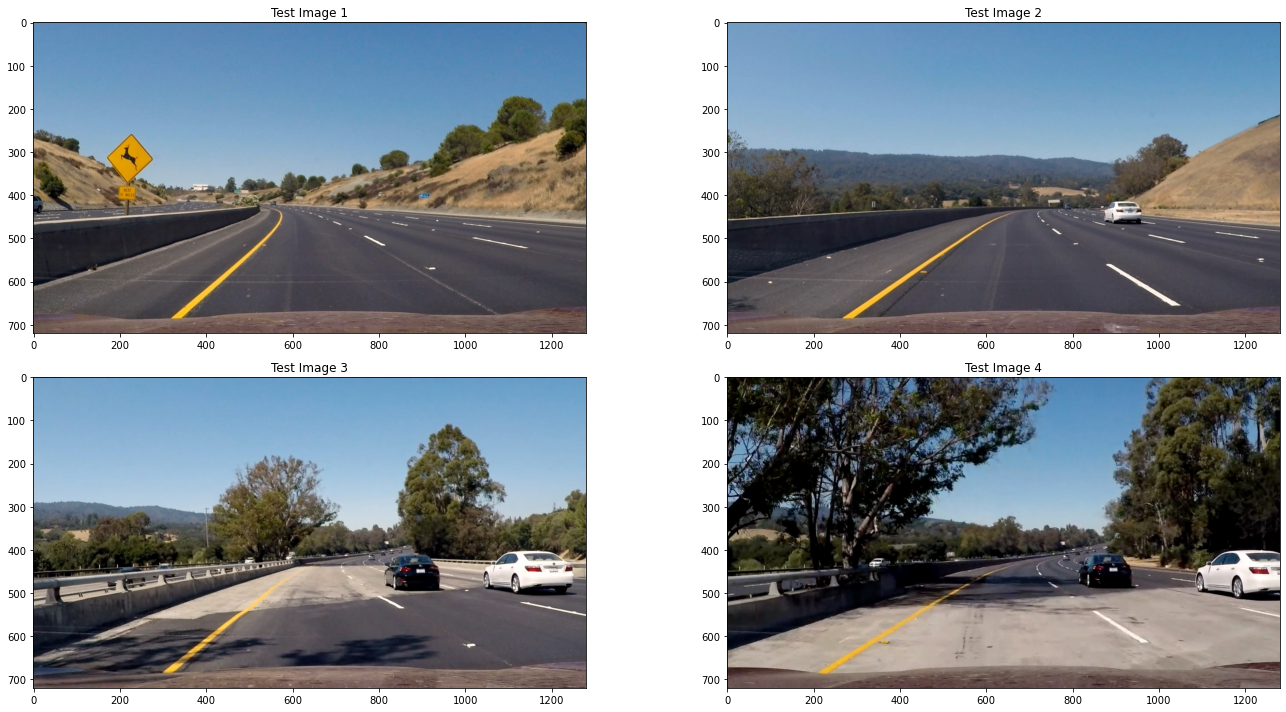

In [21]:
test_images = processor.read_and_show_test_image('test_images\*.jpg')

#### Visualize & search the windows

Visualize the windows on each test image

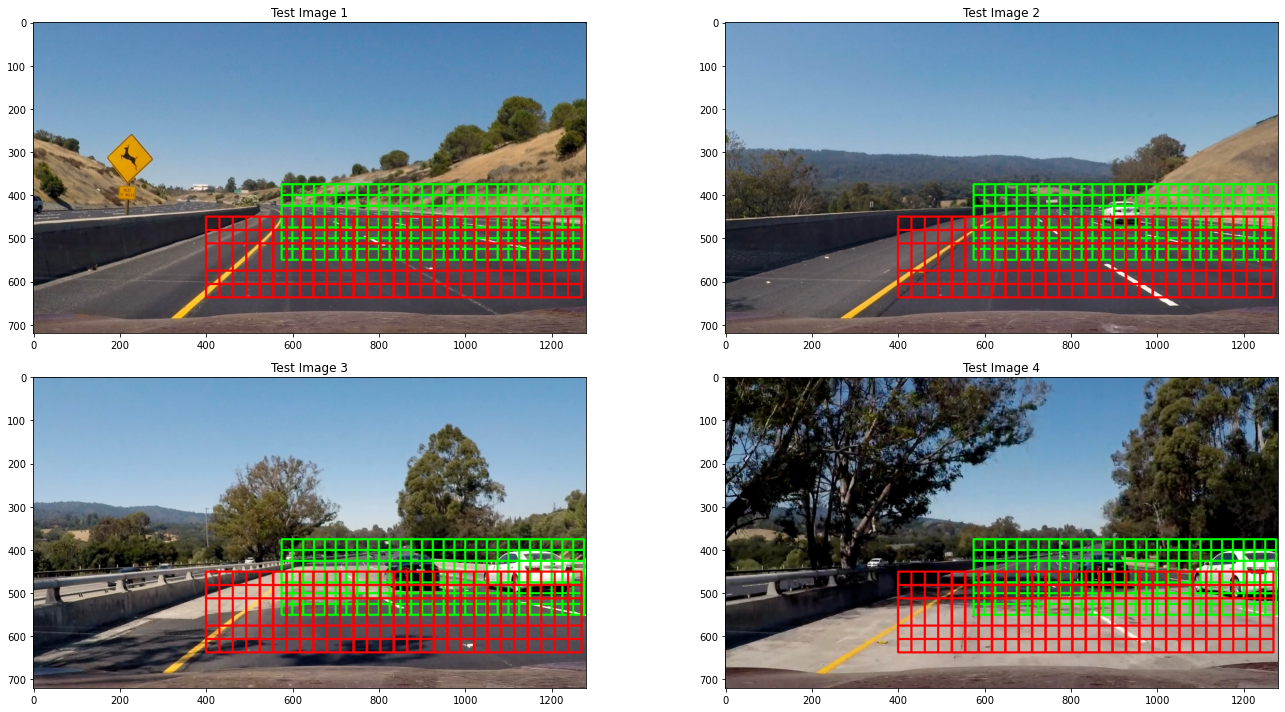

In [22]:
processor.view_windows(test_images)

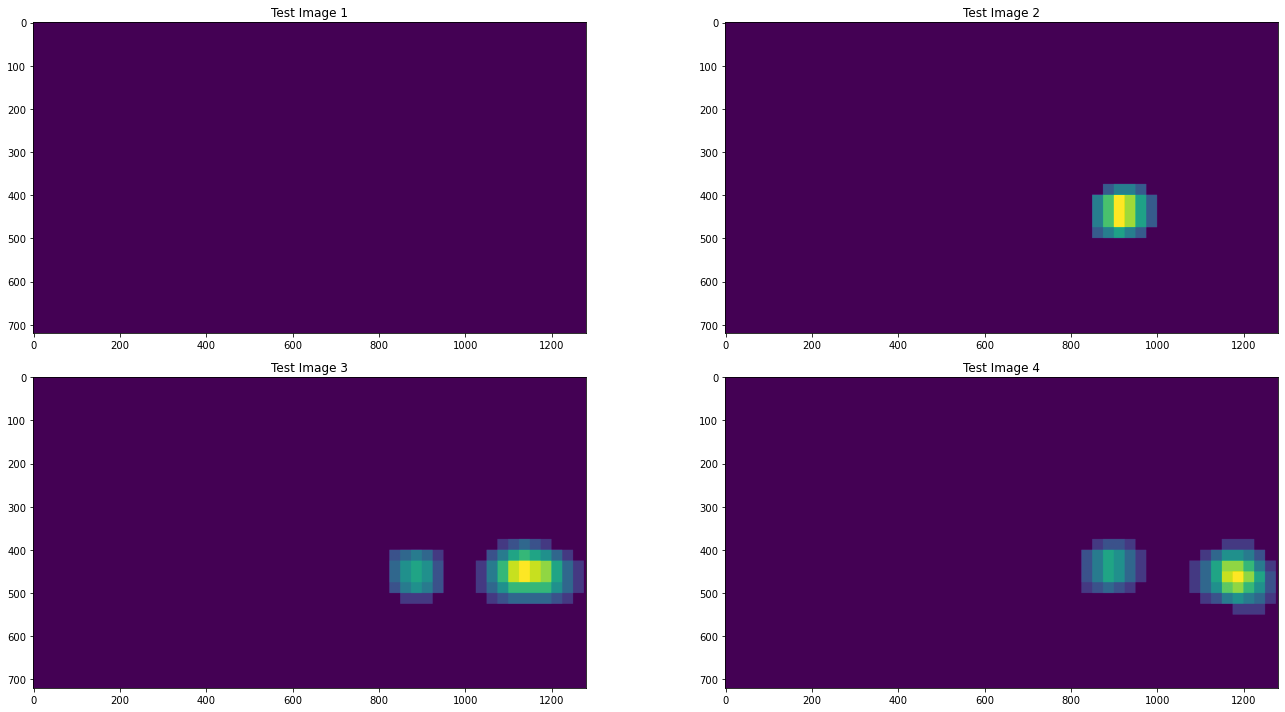

In [23]:
processor.visual_box(test_images, 'heatmap', 'CNN')

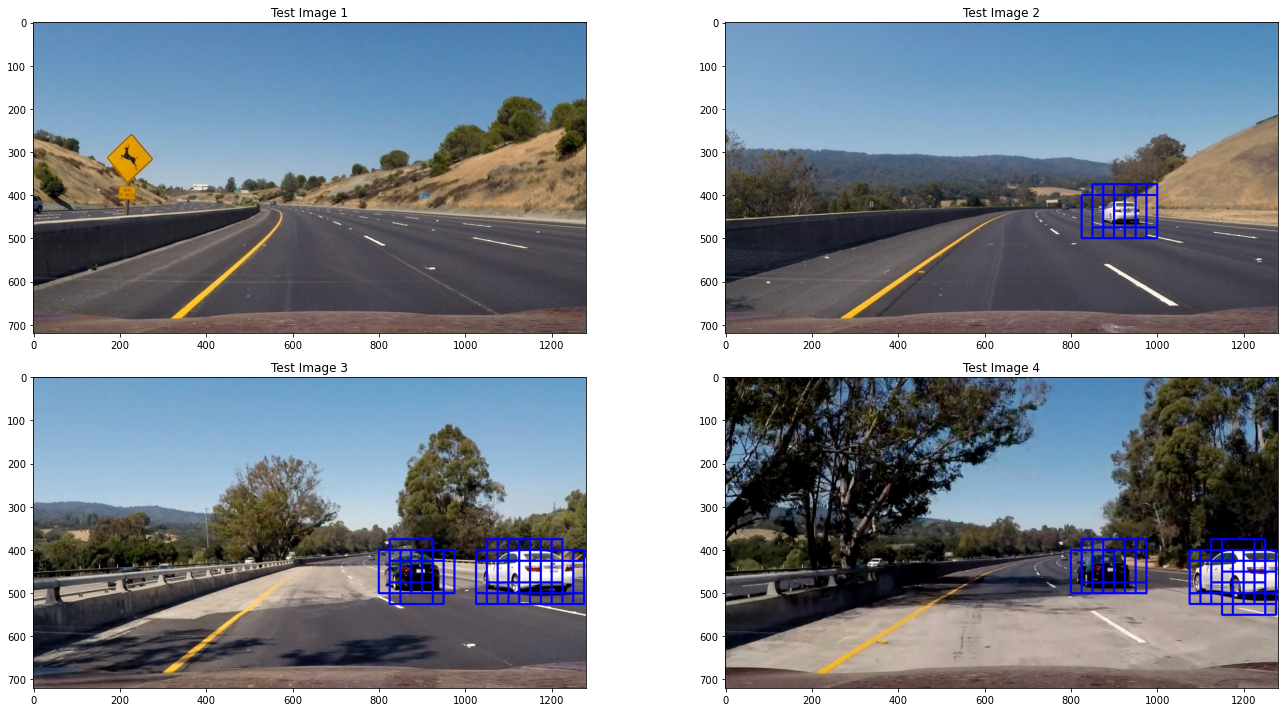

In [24]:
processor.visual_box(test_images,'boxes', 'CNN')

object_id: 0
bbox0: (850, 375)
bbox1: (999, 499)

object_id: 0
bbox0: (1025, 375)
bbox1: (1274, 524)

object_id: 1
bbox0: (825, 400)
bbox1: (949, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (974, 499)

object_id: 1
bbox0: (1075, 375)
bbox1: (1274, 549)



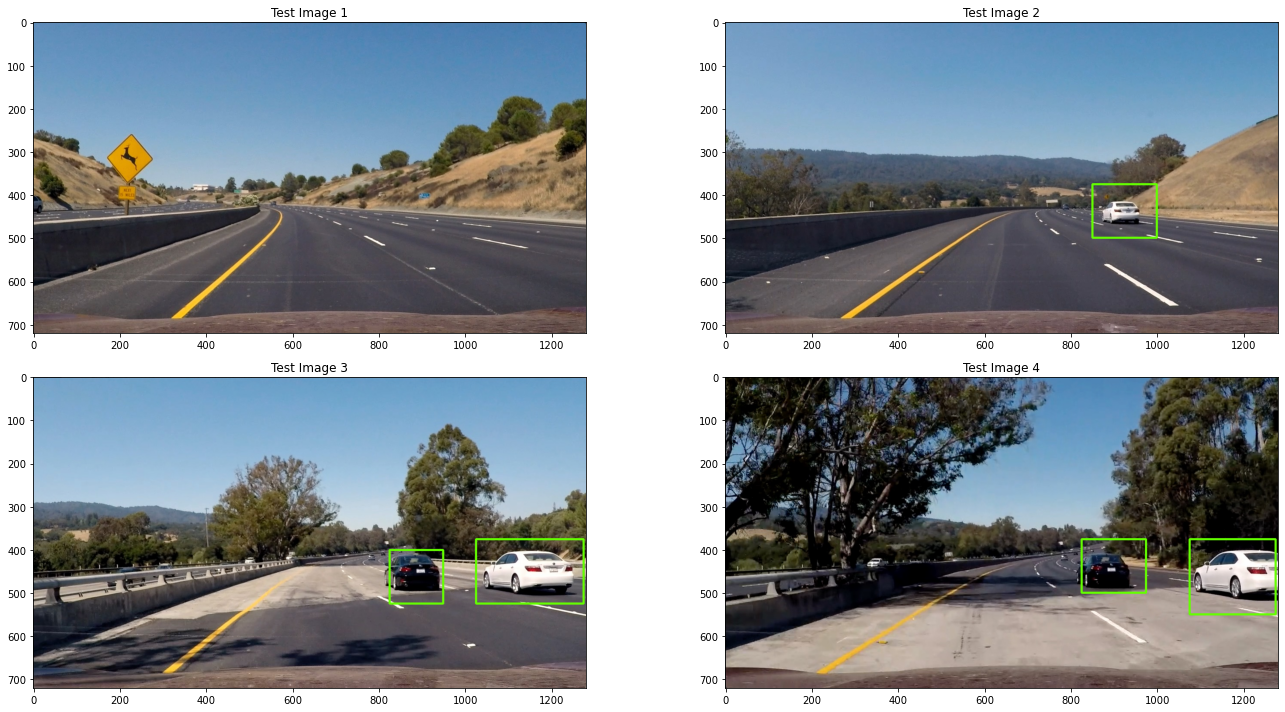

In [25]:
processor.visual_box(test_images, 'CNN')

In [26]:
project_output = '.\\output_videos\\project_output_CNN.mp4'
clip1 = VideoFileClip("test_videos/test_video.mp4")
clip = clip1.fl_image(processor.vehicle_detection)
%time clip.write_videofile(project_output, audio=False)
clip.reader.close()

t:   0%|                                                                              | 0/38 [00:00<?, ?it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1199, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)

Moviepy - Building video .\output_videos\project_output_NN.mp4.
Moviepy - Writing video .\output_videos\project_output_NN.mp4

object_id: 0
bbox0: (1000, 375)
bbox1: (1199, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  11%|███████▎                                                              | 4/38 [00:01<00:09,  3.76it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1199, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 499)

object_id: 0
bbox0: (1000, 375)
bbox1: (1199, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  16%|███████████                                                           | 6/38 [00:01<00:06,  5.07it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1000, 375)
bbox1: (1199, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  21%|██████████████▋                                                       | 8/38 [00:01<00:05,  5.56it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  26%|██████████████████▏                                                  | 10/38 [00:02<00:04,  6.27it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  32%|█████████████████████▊                                               | 12/38 [00:02<00:03,  6.62it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 499)



t:  37%|█████████████████████████▍                                           | 14/38 [00:02<00:03,  6.98it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 1
bbox0: (800, 400)
bbox1: (949, 524)



t:  42%|█████████████████████████████                                        | 16/38 [00:03<00:03,  6.96it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1000, 375)
bbox1: (1224, 524)

object_id: 0
bbox0: (800, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 375)
bbox1: (1224, 524)



t:  47%|████████████████████████████████▋                                    | 18/38 [00:03<00:02,  6.95it/s, now=None]

object_id: 0
bbox0: (800, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (1000, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (825, 400)
bbox1: (949, 524)



t:  53%|████████████████████████████████████▎                                | 20/38 [00:03<00:02,  6.73it/s, now=None]

object_id: 0
bbox0: (1000, 375)
bbox1: (1249, 524)

object_id: 1
bbox0: (825, 400)
bbox1: (949, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 375)
bbox1: (1249, 524)



t:  58%|███████████████████████████████████████▉                             | 22/38 [00:03<00:02,  6.92it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1000, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)



t:  63%|███████████████████████████████████████████▌                         | 24/38 [00:04<00:02,  6.89it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)



t:  68%|███████████████████████████████████████████████▏                     | 26/38 [00:04<00:01,  6.62it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)



t:  74%|██████████████████████████████████████████████████▊                  | 28/38 [00:04<00:01,  6.92it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)



t:  79%|██████████████████████████████████████████████████████▍              | 30/38 [00:05<00:01,  7.07it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)



t:  84%|██████████████████████████████████████████████████████████           | 32/38 [00:05<00:00,  7.25it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 499)

object_id: 1
bbox0: (1025, 375)
bbox1: (1249, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)



t:  89%|█████████████████████████████████████████████████████████████▋       | 34/38 [00:05<00:00,  7.26it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)



t:  95%|█████████████████████████████████████████████████████████████████▎   | 36/38 [00:05<00:00,  7.37it/s, now=None]

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)

object_id: 0
bbox0: (1025, 375)
bbox1: (1274, 524)

object_id: 1
bbox0: (825, 400)
bbox1: (949, 524)



t: 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  7.28it/s, now=None]

object_id: 0
bbox0: (1025, 375)
bbox1: (1274, 524)

object_id: 1
bbox0: (825, 400)
bbox1: (949, 524)

object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)



object_id: 0
bbox0: (825, 375)
bbox1: (949, 524)

object_id: 1
bbox0: (1025, 375)
bbox1: (1274, 524)

Moviepy - Done !
Moviepy - video ready .\output_videos\project_output_NN.mp4
Wall time: 7.31 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))